# Agentic Narrative Overlay: From Macro Threats to Stock-Specific Insights
**Objective:** This notebook provides an interactive walkthrough of the AI agent's analysis, demonstrating how it connects the June 2025 geopolitical spike to specific portfolio risks and opportunities. It serves as the qualitative "story" behind the quantitative analysis in the previous notebooks.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from pathlib import Path

# File paths (relative to the notebooks/ folder)
level1_path = Path('..') / 'out' / 'agentic_outputs' / 'level1_threat_clusters.json'
level2_path = Path('..') / 'out' / 'agentic_outputs' / 'level2_portfolio_analysis.json'
level3_path = Path('..') / 'out' / 'agentic_outputs' / 'level3_stock_deepdive.json'

# Load JSON files
with open(level1_path, 'r', encoding='utf-8') as f:
    level1_data = json.load(f)
with open(level2_path, 'r', encoding='utf-8') as f:
    level2_data = json.load(f)
with open(level3_path, 'r', encoding='utf-8') as f:
    level3_data = json.load(f)

# Helper: styled dataframe display
def display_styled_df(df):
    df_display = df.copy()

    # Format numeric columns to 2 decimals when reasonable
    for col in df_display.select_dtypes(include=['float', 'int']).columns:
        df_display[col] = df_display[col].round(2)

    sty = df_display.style.set_table_styles([{"selector": "td", "props": [["text-align", "left"]] }])

    # Color coding helper
    def color_verdict(val):
        try:
            s = str(val).lower()
        except Exception:
            return ''
        if any(k in s for k in ['neg', 'vulner', 'maybe', 'not_affected']):
            return 'color: red'
        if any(k in s for k in ['pos', 'positive', 'likely', 'benefit']):
            return 'color: green'
        return ''

    # Apply color to common columns if they exist
    for col in ['Verdict', 'Direction', 'final_exposure_verdict', 'impact_direction_final', 'final_view', 'Direction']:
        if col in df_display.columns:
            sty = sty.applymap(color_verdict, subset=[col])

    display(sty)

print('Agentic outputs loaded:', level1_path, level2_path, level3_path)

Agentic outputs loaded: ..\out\agentic_outputs\level1_threat_clusters.json ..\out\agentic_outputs\level2_portfolio_analysis.json ..\out\agentic_outputs\level3_stock_deepdive.json


## Section 1: The Macro Story - Geopolitical Threat Clusters
The first step in the agent's analysis is to interpret the GPR spike by identifying distinct geopolitical threat clusters and the economic channels through which they might impact markets.

In [2]:
# Extract channels_by_cluster and build summary table
clusters = level1_data.get('channels_by_cluster', [])
rows = []
for c in clusters:
    channel_types = []
    for ch in c.get('economic_channels', []):
        if 'channel_type' in ch:
            channel_types.append(ch['channel_type'])
    rows.append({
        'Cluster ID': c.get('cluster_id'),
        'Threat Category': c.get('threat_category'),
        'Region': c.get('region'),
        'Primary Actors': ', '.join(c.get('primary_actors', [])),
        'Key Economic Channels': ', '.join(channel_types)
    })
df_clusters = pd.DataFrame(rows)
display_styled_df(df_clusters)

,Cluster ID,Threat Category,Region,Primary Actors,Key Economic Channels
0,cluster_001_iran_escalation,escalation_of_war,Middle East,"United States, Israel, Iran, Islamic Revolutionary Guard Corps (IRGC)","energy_commodity, trade_disruption, macro_demand_confidence"
1,cluster_002_terror_advisories,terror_threats,North America,"Iran-linked actors (hackers/proxies), US Department of Homeland Security, FBI, Domestic lone actors","cyber_security, defense_security_spending"
2,cluster_003_unscrutiny_unscr,peace_threats,Global,"United Nations Security Council, United States Mission to the United Nations, UN member states","diplomatic_sanctions, macro_demand_confidence"
3,cluster_004_wider_theatre_escalation,escalation_of_war,Europe | Asia-Pacific,"Russia, Ukraine, India, Pakistan, NATO / Western states","macro_systemic_risk, energy_commodity, supply_chain"


## Section 2: The Portfolio Impact - Executive Summary
Next, the agent assesses the portfolio's exposure to these macro clusters, producing a high-level summary for a portfolio manager: a ranked list of the most impactful themes and a priority watchlist of affected holdings.

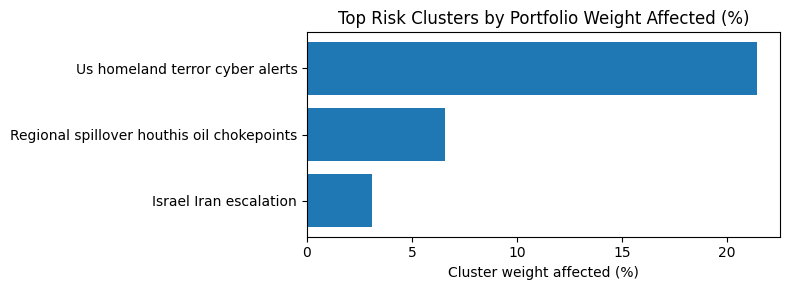

In [3]:
# Top risk clusters chart
top_risk = level2_data.get('portfolio_overview', {}).get('top_risk_clusters', [])
df_top = pd.DataFrame(top_risk)
if not df_top.empty:
    df_top_plot = df_top.copy()
    df_top_plot = df_top_plot.sort_values('cluster_weight_pct')
    fig, ax = plt.subplots(figsize=(8, max(3, len(df_top_plot) * 0.6)))
    ax.barh(df_top_plot['cluster_label'], df_top_plot['cluster_weight_pct'], color='tab:blue')
    ax.set_xlabel('Cluster weight affected (%)')
    ax.set_title('Top Risk Clusters by Portfolio Weight Affected (%)')
    plt.tight_layout()
    plt.show()
else:
    print('No top risk clusters found in level2 data')

In [4]:
# Top watchlist holdings table
watchlist = level2_data.get('portfolio_overview', {}).get('top_watchlist_holdings', [])
rows = []
for h in watchlist:
    rows.append({
        'Company': h.get('company_name'),
        'Ticker': h.get('resolved_symbol'),
        'Weight (%)': h.get('weight_pct'),
        'Verdict': h.get('final_exposure_verdict'),
        'Direction': h.get('impact_direction_final'),
        'Recommended Action': h.get('recommendation_action'),
        'Recommendation Priority': h.get('recommendation_priority'),
        'Summary Rationale': h.get('summary')
    })
df_watch = pd.DataFrame(rows)
display_styled_df(df_watch)

C:\Users\victo\AppData\Local\Temp\ipykernel_24936\2028247733.py:46: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  sty = sty.applymap(color_verdict, subset=[col])


,Company,Ticker,Weight (%),Verdict,Direction,Recommended Action,Recommendation Priority,Summary Rationale
0,MICROSOFT,MSFT,3.440000,likely_affected,positive,monitor_closely,high,Microsoft positioned to benefit from increased cybersecurity demand due to Iran-linked cyber threats; substantial portfolio weight requires active monitoring.
1,AGNICO EAGLE MINES,AEM.TO,0.560000,likely_affected,positive,no_change,medium,Gold miner likely beneficiary of safe-haven flows during Middle East escalation; modest position with clear positive exposure.
2,CHENIERE ENERGY,LNG,0.520000,likely_affected,positive,no_change,medium,LNG exporter benefits from energy risk premia and potential oil price spikes from Middle East tensions; policy-compliant energy exposure.
3,ALLIANZ,ALV.DE,0.780000,maybe_affected,ambiguous,risk_review,medium,Insurance exposure to marine and geopolitical risks creates ambiguous impact; substantial portfolio weight warrants risk review.
4,POSTE ITALIANE,PST.MI,0.510000,maybe_affected,negative,monitor_closely,medium,Logistics operations potentially affected by Red Sea shipping disruptions; moderate exposure requires monitoring.


## Section 3: Interactive Drill-Down by Cluster
This section provides a detailed, interactive view of each risk cluster. Select a cluster from the dropdown to see a full breakdown of its impact on the portfolio and the specific holdings affected.

In [5]:
# Interactive cluster drill-down
cluster_options = [(c.get('cluster_label', c.get('cluster_id')), c.get('cluster_id')) for c in level2_data.get('clusters', []) if c.get('cluster_id')]
cluster_dropdown = widgets.Dropdown(options=cluster_options, description='Cluster:')
company_dropdown = widgets.Dropdown(options=[], description='Company:')

def on_cluster_change(change):
    if change.get('name') != 'value':
        return
    selected = change.get('new')
    # find cluster
    cluster = next((c for c in level2_data.get('clusters', []) if c.get('cluster_id') == selected), None)
    portfolio_summary = cluster.get('cluster_risk_summary', {}).get('portfolio_impact_summary') or cluster.get('cluster_risk_summary', {}).get('portfolio_impact_summary','')
    display(Markdown(portfolio_summary))
    # Holdings table
    holdings = cluster.get('holdings', [])
    if holdings:
        df_h = pd.DataFrame(holdings)
        cols = [col for col in ['company_name','resolved_symbol','weight_pct','final_exposure_verdict','final_view'] if col in df_h.columns]
        if not cols:
            df_h_display = df_h.head(10)
        else:
            df_h_display = df_h[cols].rename(columns={'company_name':'Company','resolved_symbol':'Ticker','weight_pct':'Weight (%)','final_exposure_verdict':'Verdict','final_view':'Final View'})
        display_styled_df(df_h_display)
    else:
        display(Markdown('*No holdings listed for this cluster.*'))
    # Populate company dropdown with available companies
    company_options = []
    for h in holdings:
        name = h.get('company_name') or h.get('resolved_symbol')
        sym = h.get('resolved_symbol') or name
        if name:
            company_options.append((f"{name} ({sym})", sym))
    if not company_options:
        company_options = [("No companies", None)]
    company_dropdown.options = company_options

cluster_dropdown.observe(on_cluster_change, names='value')
display(cluster_dropdown)

Dropdown(description='Cluster:', options=(('Israel Iran escalation', 'cluster_01_israel_iran_escalation'), ('R…

## Section 4: The Deep Dive - Stock-Specific Narratives
Finally, we can explore the agent's detailed, evidence-based reasoning for any individual stock. This view synthesizes news context with fundamental business model analysis to arrive at a final verdict and recommended action.

In [6]:
# Deep dive: company dossier linked to the selected cluster
def find_level3_by_symbol(sym):
    for cl in level3_data.get('clusters', []):
        for list_name in ['likely_affected_holdings', 'maybe_affected_holdings']:
            for h in cl.get(list_name, []) or []:
                if not h:
                    continue
                if h.get('resolved_symbol') == sym or h.get('company_name') == sym:
                    return h, cl
    return None, None

def find_level2_by_symbol(sym):
    for cl in level2_data.get('clusters', []):
        for h in cl.get('holdings', []) or []:
            if not h:
                continue
            if h.get('resolved_symbol') == sym or h.get('company_name') == sym:
                return h, cl
    # fallback to top_watchlist
    for h in level2_data.get('portfolio_overview', {}).get('top_watchlist_holdings', []) or []:
        if h.get('resolved_symbol') == sym or h.get('company_name') == sym:
            return h, None
    return None, None

def on_company_change(change):
    if change.get('name') != 'value':
        return
    sym = change.get('new')
    if not sym:
        return
    clear_output(wait=True)
    display(cluster_dropdown)
    display(company_dropdown)
    # find details in level3 and level2
    lvl3, cl3 = find_level3_by_symbol(sym)
    lvl2, cl2 = find_level2_by_symbol(sym)
    name = (lvl3.get('company_name') if lvl3 else (lvl2.get('company_name') if lvl2 else sym))
    ticker = sym
    # Header
    md_lines = [f"# {name} — {ticker}"]
    # Verdicts
    verdict = (lvl2.get('final_exposure_verdict') if lvl2 and lvl2.get('final_exposure_verdict') else (lvl3.get('exposure_verdict') if lvl3 else 'N/A'))
    direction = (lvl2.get('impact_direction_final') if lvl2 and lvl2.get('impact_direction_final') else (lvl3.get('impact_direction') if lvl3 else 'N/A'))
    confidence = (lvl2.get('final_confidence') if lvl2 and lvl2.get('final_confidence') else (lvl3.get('confidence') if lvl3 else 'N/A'))
    md_lines.append(f"**Final Verdict:** {verdict}  ")
    md_lines.append(f"**Impact Direction:** {direction}  ")
    md_lines.append(f"**Confidence:** {confidence}  ")
    md_lines.append('')
    # Market & News Context
    news = (lvl2.get('news_angle') if lvl2 and lvl2.get('news_angle') else (lvl3.get('rationale') if lvl3 else None))
    md_lines.append('## Market & News Context')
    md_lines.append(news if news else 'No news angle available.')
    md_lines.append('')
    # Business Model Impact
    fund = (lvl2.get('fundamentals_angle') if lvl2 and lvl2.get('fundamentals_angle') else None)
    md_lines.append('## Business & Fundamentals Impact')
    if fund:
        # If dict-like, join values; else show raw
        if isinstance(fund, dict):
            md_lines.append('\n'.join([str(v) for v in fund.values()]))
        else:
            md_lines.append(str(fund))
    else:
        md_lines.append('No fundamentals angle available.')
    md_lines.append('')
    # Synthesized Rationale
    final_view = (lvl2.get('final_view') if lvl2 and lvl2.get('final_view') else (lvl3.get('rationale') if lvl3 else None))
    md_lines.append('## Synthesized Rationale')
    md_lines.append(final_view if final_view else 'No synthesized rationale available.')
    md_lines.append('')
    # Recommended Action
    rec_action = (lvl2.get('recommendation_action') if lvl2 and lvl2.get('recommendation_action') else 'N/A')
    rec_prio = (lvl2.get('recommendation_priority') if lvl2 and lvl2.get('recommendation_priority') else 'N/A')
    md_lines.append('**Recommended Action:** ' + str(rec_action) + '  ')
    md_lines.append('**Recommendation Priority:** ' + str(rec_prio) + '  ')
    # Display the dossier
    display(Markdown('\n'.join(md_lines)))

# Wire the company dropdown to the handler
company_dropdown.observe(on_company_change, names='value')

# Display the company dropdown (it will be populated when a cluster is selected)
display(company_dropdown)

Dropdown(description='Company:', options=(), value=None)